In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [2]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [3]:
#Training Dataset
# Set train shuffle seed (for reproducibility)
manual_seed(42)
batch_size = 32
training_samples = 500
test_samples = 250

# Use pre-defined torchvision function to load MNIST train data
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

subset = []
for i in range(2):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)
    
full_training_data.data = full_training_data.data[subset]
full_training_data.targets = full_training_data.targets[subset]

#Split training dataset into training and validation (80%-20%)
train_size = int(0.8 * len(full_training_data))
valid_size = len(full_training_data) - train_size

train, valid = random_split(full_training_data, [train_size, valid_size])

test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

subset = []
for i in range(2):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
print("Valid subset size:", len(valid))
print("Test subset size:", len(test))

def count(dataset):
    counter = {}
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
        
print("Training Dataset")
count(train)

print("Validation Dataset")
count(valid)

print("Testing Dataset")
count(test)

# Define torch dataloader with filtered data
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

Train subset size: 800
Valid subset size: 200
Test subset size: 500
Training Dataset
0 : 413
1 : 387
Validation Dataset
0 : 87
1 : 113
Testing Dataset
0 : 250
1 : 250


The training dataset has 800 images
After the shuffle the 0th image has class index 1
Image shape is (28, 28, 1)


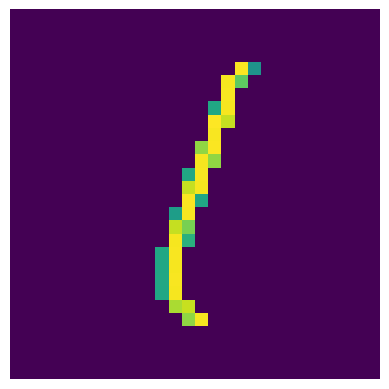

1
After the shuffle the 0th image has class index 0
Image shape is (28, 28, 1)


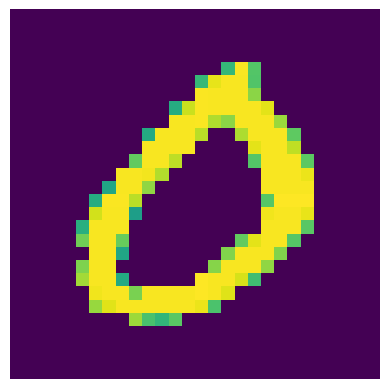

0


In [4]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)
    # im_np[im_np > 0.5] = 1
    im_np[im_np < 0.5] = 0

    # Display the image
    plt.imshow(im_np[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(class_idx)

The validation dataset has 200 images
After the shuffle the 0th image has class index 1
Image shape is (28, 28, 1)


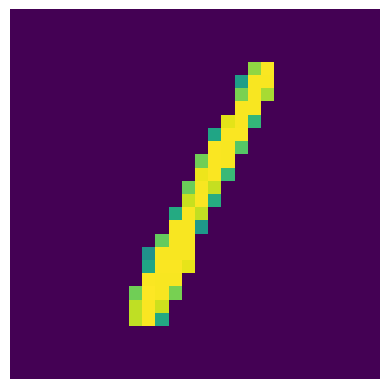

1
After the shuffle the 0th image has class index 1
Image shape is (28, 28, 1)


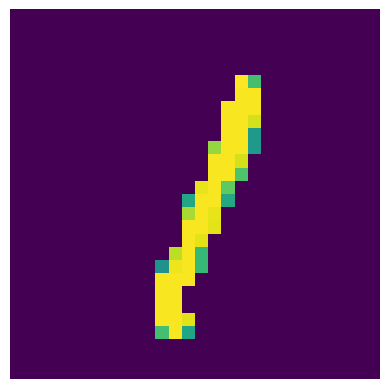

1


In [5]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid)
print(f'The validation dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = valid[indices[0]]
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)
    # im_np[im_np > 0.5] = 1
    im_np[im_np < 0.5] = 0

    # Display the image
    plt.imshow(im_np[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(class_idx)

The testing dataset has 500 images
After the shuffle the 0th image has class index 0
Image shape is (28, 28, 1)


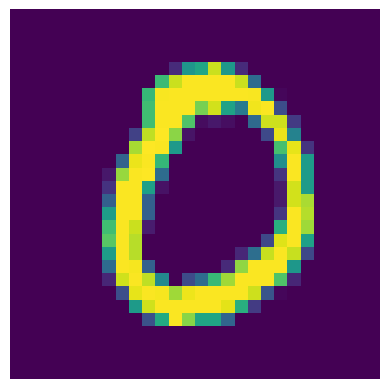

0
After the shuffle the 0th image has class index 1
Image shape is (28, 28, 1)


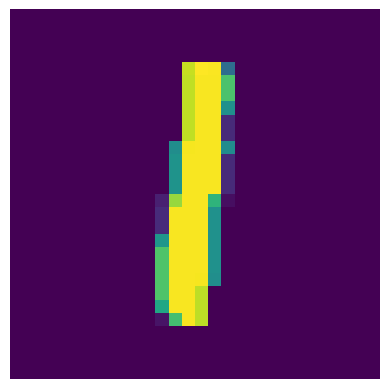

1


In [6]:
# Find and output the number of images
n = len(test)
print(f'The testing dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = test[indices[0]]
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)

    # Display the image
    plt.imshow(im_np)
    plt.axis('off')
    plt.show()
    print(class_idx)

In [7]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64
Using cuda device


In [8]:
'''
Neural Networks
'''

# # Define and create QNN
# def create_qnn():
#     feature_map = ZZFeatureMap(2)
#     ansatz = RealAmplitudes(2, reps=1)
#     qc = QuantumCircuit(2)
#     qc.compose(feature_map, inplace=True)
#     qc.compose(ansatz, inplace=True)

#     # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
#     qnn = EstimatorQNN( 
#         circuit=qc,
#         input_params=feature_map.parameters,
#         weight_params=ansatz.parameters,
#         input_gradients=True,
#     )
#     return qnn

# Define torch NN module
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 20, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(320, 64)
        self.fc2 = Linear(64, 16)
        self.replacement1 = Linear(16, 2)
        self.replacement2 = Linear(2, 1)
        #self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc3 = Linear(1, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.replacement1(x))
        #x = self.qnn(x)  # apply QNN
        x = self.replacement2(x)
        x = self.fc3(x)
        return x

In [9]:
#qnn4 = create_qnn()
model4 = Net().to(device)

print(model4)
for p in model4.parameters():
    print(p.size())
    
print()
mb = torch.rand(batch_size, 1, 28, 28).to(device)
logits = model4.forward(mb)
print(logits.size())

Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (replacement1): Linear(in_features=16, out_features=2, bias=True)
  (replacement2): Linear(in_features=2, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=2, bias=True)
)
torch.Size([2, 1, 5, 5])
torch.Size([2])
torch.Size([20, 2, 5, 5])
torch.Size([20])
torch.Size([64, 320])
torch.Size([64])
torch.Size([16, 64])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])
torch.Size([1, 2])
torch.Size([1])
torch.Size([2, 1])
torch.Size([2])

torch.Size([32, 2])


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    training_loss = 0.0
    total_loss = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        total_loss.append(loss.item())
    training_loss /= len(dataloader)
    return total_loss, training_loss

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    #so that we do not compute gradients, only model performance
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            test_loss += loss_fn(output, y)
    test_loss /= num_batches
    correct /= size
    return correct

def time_elapsed(start):
    delta = datetime.now() - start
    m, s = divmod(delta.seconds, 60)
    h, m = divmod(m, 60)
    return f'Time elapsed: {h}h {m}m {int(s)}s'

In [11]:
from torch import nn
from datetime import datetime

loss_fn = nn.CrossEntropyLoss()
# loss_fn = NLLLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=1e-4)
# optimizer = optim.Adam(model4.parameters(), lr=0.001)

epochs = 50
loss_list = []  # Store loss history
start = datetime.now()
# for epoch in range(epochs):
#     total_loss = []
#     for batch_idx, (data, target) in enumerate(train_dataloader):
#         optimizer.zero_grad(set_to_none=True)  # Initialize gradient
#         output = model4(data)  # Forward pass
#         loss = loss_fn(output, target)  # Calculate loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Optimize weights
#         total_loss.append(loss.item())  # Store loss
#     loss_list.append(sum(total_loss) / len(total_loss))
#     print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

best_accuracy = 0
best_model = 'best_model.pth'

for epoch in range(epochs):
    total_loss, training_loss = train(train_dataloader, model4, loss_fn, optimizer)
    validation_accuracy = validate(valid_dataloader, model4, loss_fn)
    if (validation_accuracy > best_accuracy):
        best_accuracy = validation_accuracy
        #save the model 
        torch.save(model4, best_model)
        print("Epoch:", epoch)
        # print("Training Loss:", training_loss)
        print("Accuracy:", best_accuracy)
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    print(time_elapsed(start))
    print()
print("Done!")

Epoch: 0
Accuracy: 0.565
Training [2%]	Loss: 0.7049
Time elapsed: 0h 0m 0s

Training [4%]	Loss: 0.7048
Time elapsed: 0h 0m 0s

Training [6%]	Loss: 0.7048
Time elapsed: 0h 0m 0s

Training [8%]	Loss: 0.7047
Time elapsed: 0h 0m 0s

Training [10%]	Loss: 0.7047
Time elapsed: 0h 0m 0s

Training [12%]	Loss: 0.7047
Time elapsed: 0h 0m 1s

Training [14%]	Loss: 0.7046
Time elapsed: 0h 0m 1s

Training [16%]	Loss: 0.7046
Time elapsed: 0h 0m 1s

Training [18%]	Loss: 0.7046
Time elapsed: 0h 0m 1s

Training [20%]	Loss: 0.7045
Time elapsed: 0h 0m 1s

Training [22%]	Loss: 0.7045
Time elapsed: 0h 0m 1s

Training [24%]	Loss: 0.7044
Time elapsed: 0h 0m 2s

Training [26%]	Loss: 0.7044
Time elapsed: 0h 0m 2s

Training [28%]	Loss: 0.7044
Time elapsed: 0h 0m 2s

Training [30%]	Loss: 0.7043
Time elapsed: 0h 0m 2s

Training [32%]	Loss: 0.7043
Time elapsed: 0h 0m 2s

Training [34%]	Loss: 0.7043
Time elapsed: 0h 0m 3s

Training [36%]	Loss: 0.7042
Time elapsed: 0h 0m 3s

Training [38%]	Loss: 0.7042
Time elapsed: 0

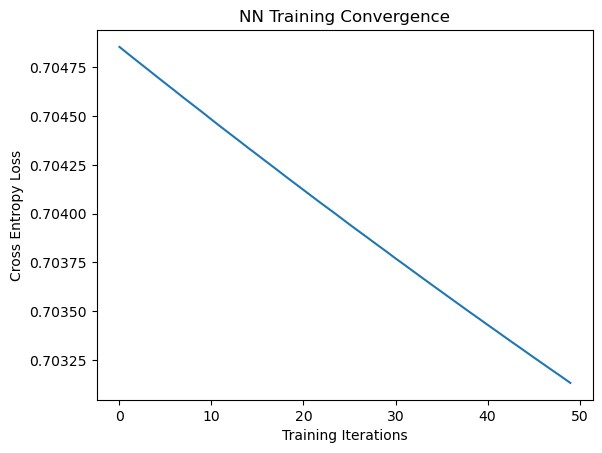

In [12]:
#Plot loss convergence
plt.plot(loss_list)
plt.title("NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [13]:
def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0.0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            output = model5(X)
            
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

            loss = loss_fn(output, y)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(dataloader) / batch_size * 100
            )
        )

# qnn5 = create_qnn()
model5 = Net().to(device)
model5 = torch.load(best_model)
test(test_dataloader, model5, loss_fn)

Performance on test data:
	Loss: 0.7020
	Accuracy: 48.8%


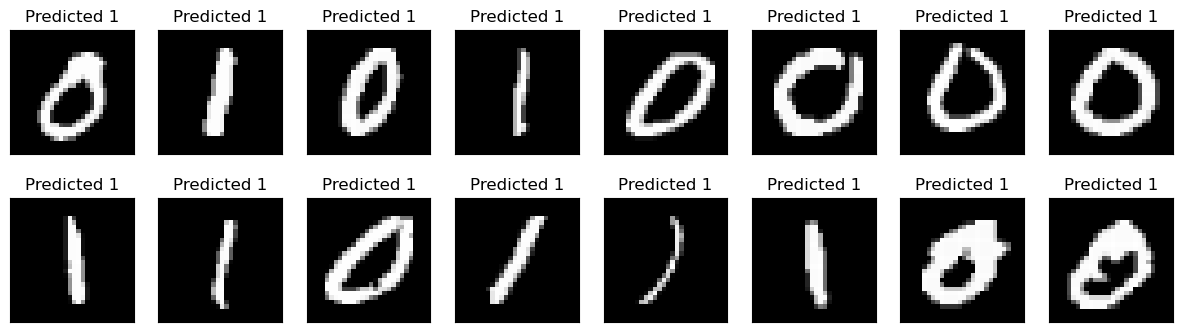

In [15]:
# Plot predicted labels
n_samples_show = 8
n_rows = 2
count = 0
fig, axes = plt.subplots(nrows=n_rows, ncols=n_samples_show, figsize=(15, 4))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        if count == n_samples_show * n_rows:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        
        row = count // n_samples_show  # Calculate row index
        col = count % n_samples_show  # Calculate column index

        axes[row, col].imshow(data[0].cpu().numpy().squeeze(), cmap="gray")

        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col].set_title("Predicted {}".format(pred.item()))

        count += 1